## CNN for plant seedling image classification
https://www.kaggle.com/vbookshelf/a-simple-keras-solution
## TODO:
 - validation set (three partition)
 - better data preparation
 - TF2 style
 - tf.Dataset or proper image dataset handling

In [1]:
from numpy.random import seed
seed(101)
from tensorflow.random import set_seed
set_seed(101)

import pandas as pd
import numpy as np

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

/home/mario/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mario/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mario/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mario/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [21]:
# Number of samples we will have in each class.
SAMPLE_SIZE = 250

# The images will all be resized to this size.
IMAGE_SIZE = 96

# path to unzipped but original data set from kaggle
IMAGE_PATH='/home/mario/Dropbox/data/seedlings/'

## Data Preparation

In [22]:
# Create a pandas dataset
df_data = pd.read_csv("classes-and-fnames.txt", sep='\t', names=['target','fname'])
df_data['image_id'] = df_data['target'] + "/" + df_data['fname']
print(df_data.head())
print("shape = ", df_data.shape)
target_list = df_data.target.unique()
K = target_list.size # number of categories
print("num categories = ", K)

        target    fname             image_id
0  Black-grass  100.png  Black-grass/100.png
1  Black-grass  101.png  Black-grass/101.png
2  Black-grass  102.png  Black-grass/102.png
3  Black-grass  103.png  Black-grass/103.png
4  Black-grass  104.png  Black-grass/104.png
shape =  (5539, 3)
num categories =  12


In [23]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification


def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    """

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()
    


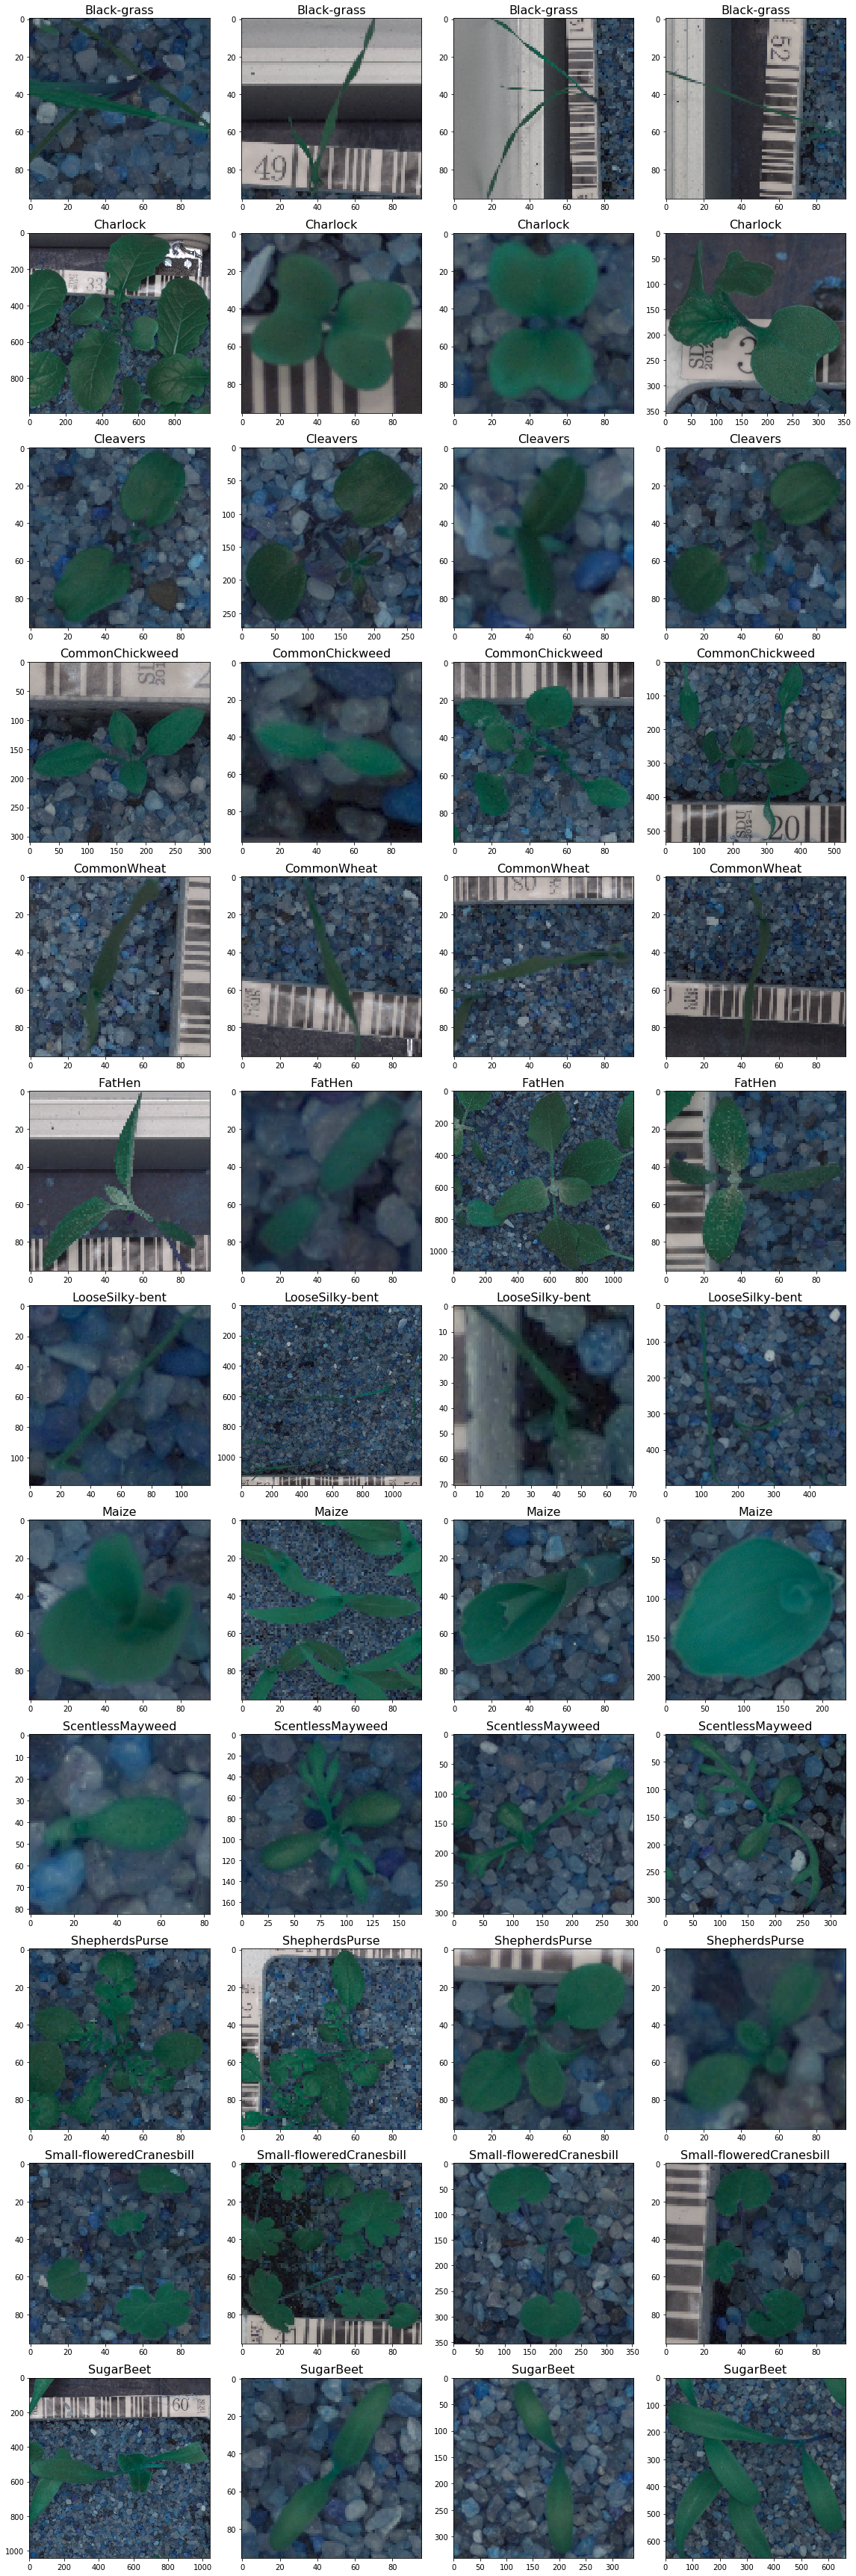

In [24]:
draw_category_images('target', 4, df_data, IMAGE_PATH)

In [25]:
df_data['target'].value_counts()

LooseSilky-bent             762
CommonChickweed             713
ScentlessMayweed            607
Small-floweredCranesbill    576
FatHen                      538
SugarBeet                   463
Charlock                    452
Cleavers                    335
Black-grass                 309
ShepherdsPurse              274
Maize                       257
CommonWheat                 253
Name: target, dtype: int64

In [26]:
# Get a list of classes
for target in target_list:

    # Filter out a target and take a random sample
    df = df_data[df_data['target'] == target].sample(SAMPLE_SIZE, random_state=101)
    
    # if it's the first item in the list
    if target == target_list[0]:
        df_sample = df
    else:
        # Concat the dataframes
        df_sample = pd.concat([df_sample, df], axis=0).reset_index(drop=True)



In [27]:
df_sample['target'].value_counts()

FatHen                      250
Maize                       250
Small-floweredCranesbill    250
ShepherdsPurse              250
Black-grass                 250
CommonWheat                 250
ScentlessMayweed            250
Cleavers                    250
SugarBeet                   250
CommonChickweed             250
Charlock                    250
LooseSilky-bent             250
Name: target, dtype: int64

In [28]:
# train_test_split

# stratify=y creates a balanced validation set.
y = df_sample['target']

df_train, df_val = train_test_split(df_sample, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(2700, 3)
(300, 3)


In [29]:
# Train set class distribution
df_train['target'].value_counts()

FatHen                      225
Maize                       225
Small-floweredCranesbill    225
ShepherdsPurse              225
Black-grass                 225
CommonWheat                 225
ScentlessMayweed            225
Cleavers                    225
SugarBeet                   225
CommonChickweed             225
Charlock                    225
LooseSilky-bent             225
Name: target, dtype: int64

In [30]:
# Val set class distribution
df_val['target'].value_counts()

Small-floweredCranesbill    25
CommonChickweed             25
Maize                       25
ShepherdsPurse              25
ScentlessMayweed            25
SugarBeet                   25
Charlock                    25
Cleavers                    25
CommonWheat                 25
FatHen                      25
LooseSilky-bent             25
Black-grass                 25
Name: target, dtype: int64

In [31]:
# resize images and move the training and testing images to subfolders
def move_and_resize(df, dirname):
    for target, fname in df[["target","fname"]].values:
        # the id in the csv file does not have the .tif extension therefore we add it here

        # source path to image
        src = os.path.join(IMAGE_PATH, target, fname)
        # destination path to image
        dst = os.path.join(dirname, target, fname)

        # resize the image and save it at the new location
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        # save the image at the destination
        cv2.imwrite(dst, image)
    
move_and_resize(df_train, "train_dir")
move_and_resize(df_val, "val_dir")

## Machine Learning

In [32]:
train_path = 'train_dir'
valid_path = 'val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 16
val_batch_size = 16

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [33]:
train_steps

169.0

In [34]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size = train_batch_size,
                                        class_mode = 'categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size = val_batch_size,
                                        class_mode = 'categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 2700 images belonging to 12 classes.
Found 300 images belonging to 12 classes.
Found 300 images belonging to 12 classes.


In [35]:
# Source: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(12, activation = "softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 41, 41, 64)       

In [36]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [37]:
# Let the model be saved every epoch
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                        validation_data = val_gen,
                        validation_steps=val_steps,
                        epochs=30, verbose=1,
                       callbacks=callbacks_list)

Epoch 1/30
168/169 [============================>.] - ETA: 0s - loss: 2.4835 - accuracy: 0.0835
Epoch 00001: val_accuracy improved from -inf to 0.08333, saving model to model.h5
169/169 [==============================] - 56s 334ms/step - loss: 2.4825 - accuracy: 0.0844 - val_loss: 2.4498 - val_accuracy: 0.0833
Epoch 2/30
168/169 [============================>.] - ETA: 0s - loss: 2.2296 - accuracy: 0.1732
Epoch 00002: val_accuracy improved from 0.08333 to 0.30000, saving model to model.h5
169/169 [==============================] - 54s 318ms/step - loss: 2.2271 - accuracy: 0.1737 - val_loss: 1.8519 - val_accuracy: 0.3000
Epoch 3/30
168/169 [============================>.] - ETA: 0s - loss: 1.8151 - accuracy: 0.3107
Epoch 00003: val_accuracy improved from 0.30000 to 0.39333, saving model to model.h5
169/169 [==============================] - 54s 319ms/step - loss: 1.8118 - accuracy: 0.3133 - val_loss: 1.5913 - val_accuracy: 0.3933
Epoch 4/30
168/169 [============================>.] - ETA:

Epoch 28/30
168/169 [============================>.] - ETA: 0s - loss: 0.2815 - accuracy: 0.8864
Epoch 00028: val_accuracy did not improve from 0.71000
169/169 [==============================] - 54s 319ms/step - loss: 0.2820 - accuracy: 0.8863 - val_loss: 1.1085 - val_accuracy: 0.7033
Epoch 29/30
168/169 [============================>.] - ETA: 0s - loss: 0.2473 - accuracy: 0.9046
Epoch 00029: val_accuracy did not improve from 0.71000

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
169/169 [==============================] - 54s 317ms/step - loss: 0.2483 - accuracy: 0.9041 - val_loss: 1.1304 - val_accuracy: 0.7000
Epoch 30/30
168/169 [============================>.] - ETA: 0s - loss: 0.2494 - accuracy: 0.9046
Epoch 00030: val_accuracy improved from 0.71000 to 0.72000, saving model to model.h5
169/169 [==============================] - 54s 318ms/step - loss: 0.2500 - accuracy: 0.9037 - val_loss: 1.1030 - val_accuracy: 0.7200


In [38]:
model.metrics_names

['loss', 'accuracy']

In [39]:
# Print the validation loss and accuracy.

# Here the best epoch will be used.
model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 1.0923803927185414
val_acc: 0.72


<Figure size 432x288 with 0 Axes>

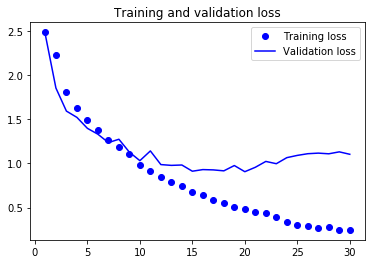

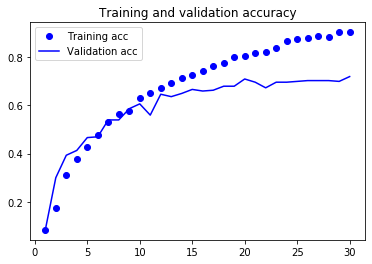

<Figure size 432x288 with 0 Axes>

In [40]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [41]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)
predictions.shape

300/300 [==============================] - 2s 7ms/step


(300, 12)

In [42]:
test_gen.class_indices

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherd’s Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [43]:
# Put the predictions into a dataframe.
# The columns need to be ordered to match the output of the previous cell

class_dict = train_gen.class_indices

# Get a list of the dict keys.
cols = class_dict.keys()

df_preds = pd.DataFrame(predictions, columns=cols)

df_preds.head()

,Black-grass,Charlock,Cleavers,Common Chickweed,Common wheat,Fat Hen,Loose Silky-bent,Maize,Scentless Mayweed,Shepherd’s Purse,Small-flowered Cranesbill,Sugar beet
0,0.465221,2.134610e-06,2.016767e-06,6.985969e-07,0.059063,0.000031,0.475607,5.863773e-06,0.000049,2.383185e-06,3.872538e-07,1.461858e-05
1,0.382852,6.108961e-08,2.255261e-07,7.079345e-08,0.056101,0.000009,0.561032,8.700899e-07,0.000004,4.172807e-07,1.891620e-08,6.772792e-07
2,0.363493,1.160474e-06,1.495099e-06,2.681554e-06,0.050959,0.000053,0.585350,7.745079e-06,0.000037,2.182663e-06,3.065655e-07,9.249216e-05
3,0.161551,1.639836e-07,4.592853e-07,1.268855e-07,0.053033,0.000013,0.785389,1.163007e-06,0.000008,7.276619e-07,2.271887e-08,3.355091e-06
4,0.136477,9.900716e-06,2.897255e-04,4.598060e-06,0.647263,0.000981,0.214360,1.867117e-05,0.000472,1.349174e-05,5.903362e-06,1.058308e-04


In [44]:
# confusion matrix
# Get the labels of the test images.

test_labels = test_gen.classes
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [45]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    # set the size of the figure here
    plt.figure(figsize=(15,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=80) # set x-axis text angle here
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 5  0  0  0  6  1 12  0  0  0  0  1]
 [ 0 21  1  0  0  0  0  1  1  1  0  0]
 [ 0  0 19  0  0  0  0  1  4  1  0  0]
 [ 0  0  0 21  0  0  0  0  1  3  0  0]
 [ 3  0  0  0 16  1  4  0  0  0  0  1]
 [ 0  0  2  0  1 20  0  0  0  1  0  1]
 [ 7  0  0  0  3  0 14  0  0  0  0  1]
 [ 0  0  0  0  1  0  0 22  1  0  0  1]
 [ 2  1  0  0  0  0  1  1 17  1  0  2]
 [ 0  0  0  3  0  0  0  1  2 19  0  0]
 [ 0  0  0  0  0  0  0  1  0  0 24  0]
 [ 0  1  0  0  1  2  0  0  1  1  1 18]]


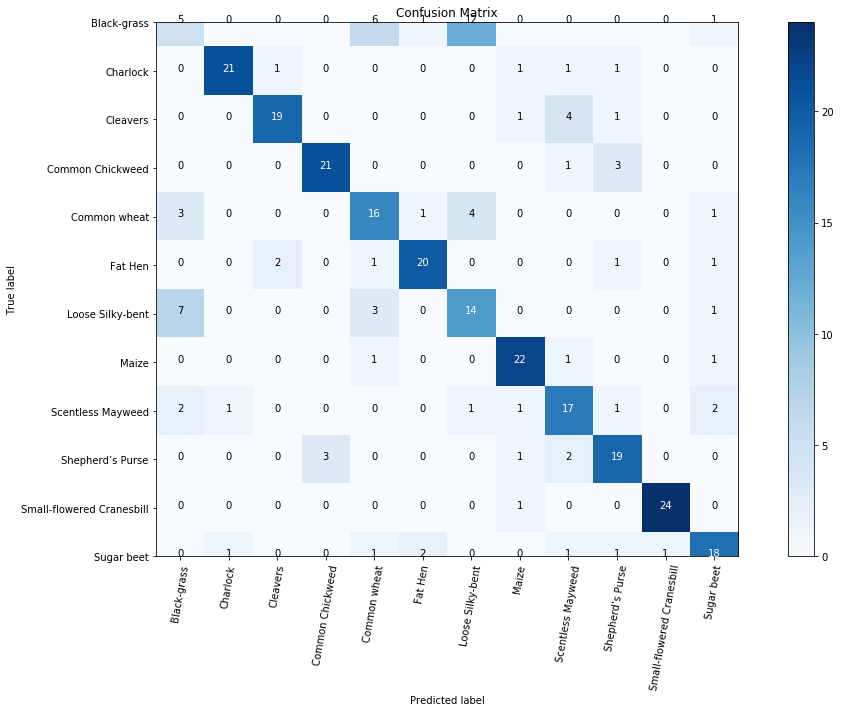

In [46]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = cols

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [47]:
from sklearn.metrics import classification_report

# Generate a classification report

# Get the true labels
y_true = test_gen.classes

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)

                           precision    recall  f1-score   support

              Black-grass       0.29      0.20      0.24        25
                 Charlock       0.91      0.84      0.87        25
                 Cleavers       0.86      0.76      0.81        25
         Common Chickweed       0.88      0.84      0.86        25
             Common wheat       0.57      0.64      0.60        25
                  Fat Hen       0.83      0.80      0.82        25
         Loose Silky-bent       0.45      0.56      0.50        25
                    Maize       0.81      0.88      0.85        25
        Scentless Mayweed       0.63      0.68      0.65        25
         Shepherd’s Purse       0.70      0.76      0.73        25
Small-flowered Cranesbill       0.96      0.96      0.96        25
               Sugar beet       0.72      0.72      0.72        25

              avg / total       0.72      0.72      0.72       300

